# MC
## 1. simple rejection sampling

In [5]:
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
%matplotlib inline 

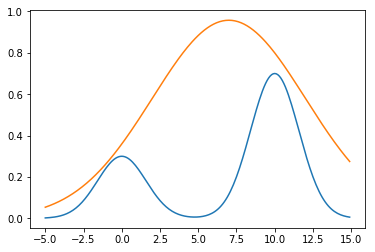

In [13]:
# unnormal p_t
f_t = lambda z: 0.3 * np.exp(-0.2 * z ** 2) + 0.7 * np.exp(-0.2 * (z - 10) ** 2)
q_z = partial(norm.pdf, loc=7, scale=5)
M = 12
X = np.arange(-5, 15, 0.1)
plt.plot(X, f_t(X))
plt.plot(X, M*q_z(X))


total 100000 ac 1112 rj 998888


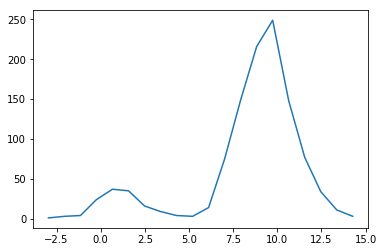

In [24]:
rj, ac = 0, 0  #count
samples = []
for _ in range(1000000):
    u = np.random.uniform()
    x = norm.rvs(loc=7, scale=5)
    if u < f_t(x) / M * q_z(x):
        ac += 1
        samples.append(x)
    else:
        rj += 1

l_ = len(samples)
histogram, bins = np.histogram(samples, 20)
bins = 0.5*(bins[1:] + bins[:-1])
plt.plot(bins, histogram)
print('total {} ac {} rj {}'.format(100000, ac, rj))

*Notes*:
> 1. 接受率很低，受维度灾难影响大，无法扩展到高维。
> 2. q_z 必须是一个能容易采样的概率分布， p_z 可以不用归一化

## 2. simple importance sampling

### p_z和q_z都是概率分布

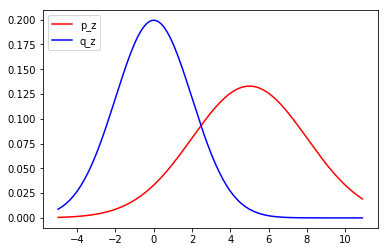

In [121]:
p_z = partial(norm.pdf, loc=5, scale=3)
q_z = partial(norm.pdf, loc=0, scale=2)
f = lambda x: x
X = np.arange(-5, 11, 0.1)
plt.plot(X, p_z(X), color='red', label='p_z')
plt.plot(X, q_z(X), color='blue', label='q_z')
# plt.plot(X, f(X), color='green', label='f_z')
plt.legend(loc='upper left')


评估期望$\mathcal{E}[f]$

In [125]:
L = 100000
# 从q_z中采L个样本,loc=0, scale=2
q_samples = norm.rvs(size=L, loc=0, scale=2)
q_q = q_z(q_samples)
p_q = p_z(q_samples)
f_z = f(q_samples)
w = p_q / q_q
e_f_p = np.mean(w * f_z)

print('E[f]: {}'.format(e_f_p))


E[f]: 5.035878405427125
